In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
import time
from sklearn.svm import LinearSVC,SVC
from sklearn import grid_search
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label
import pickle
%matplotlib inline

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
car_path = 'Data/vehicles/'
non_car_path = 'Data/non-vehicles/'

cars = []
for path in os.listdir(car_path):
    p = 'Data/vehicles/'+ path+'/*.png'
#     print(p)
    cars.append(glob.glob(p))

notcars = []
for path in os.listdir(non_car_path):
    p = 'Data/non-vehicles/'+ path+'/*.png'
    notcars.append(glob.glob(p))


cars = [item for sublist in cars for item in sublist]
notcars = [item for sublist in notcars for item in sublist]

print('Nnumber of Car Images:', len(cars))
print('Nnumber of Non-Car Images:', len(notcars))

Nnumber of Car Images: 8792
Nnumber of Non-Car Images: 8968


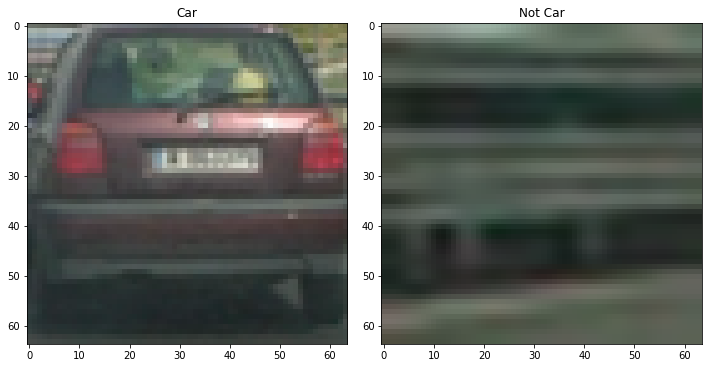

In [3]:
car_img = plt.imread(cars[0])
not_car_img = plt.imread(notcars[0])

fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(car_img)
plt.title('Car')
plt.subplot(122)
plt.imshow(not_car_img)
plt.title('Not Car')
fig.tight_layout()

# Extract features

In [4]:
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

def convert_color(img, color_space='YCrCb'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
    return feature_image   

# Define a function to compute binned color features  
def bin_spatial(img, size=32):
    # down sampling the image from (64,64) to (32,32)
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, (size,size)).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9,
                     spatial_size = 32 ,hist_bins = 24, hist_range = (0,256) ,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, vis=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'      
        feature_image = convert_color(image, cspace)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Call get_hog_features() with vis=False, feature_vec=True
        hog_features = []
        if hog_channel == 'ALL':
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis, feature_vec=True))
            hog_features = np.ravel(hog_features) # flatten 3 channels
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features,hog_features)))
#         features.append(np.concatenate((hist_features,hog_features)))
    # Return list of feature vectors
    return features

## Normalization

In [8]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb  
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 32

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        spatial_size =spatial ,hist_bins = histbin, hist_range = (0, 256),
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        spatial_size =spatial,hist_bins = histbin, hist_range = (0, 256),
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print("Feature lens:", len(scaled_X[0]))

95.48 Seconds to extract HOG features...
Feature lens: 8460


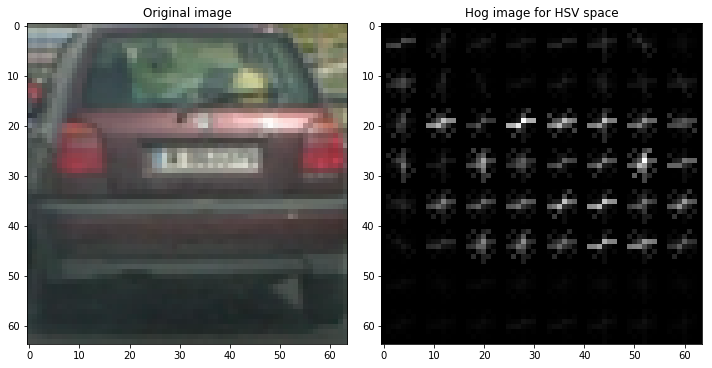

In [8]:
orient = 9 #paper says 9 can improve 
pix_per_cell = 8 # 8 is kind of size of features of cars we are looking for 
cell_per_block = 2 # 2 helps the normalization
img_HSV = cv2.cvtColor(car_img, cv2.COLOR_RGB2HSV)
features, hog_image = hog(img_HSV[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=True)
fig = plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(car_img)
plt.title('Original image')
plt.subplot(122)
plt.imshow(hog_image, cmap = 'gray')
plt.title('Hog image for HSV space')
fig.tight_layout()

## Scale the features
Spatial features: 3 chanels * 64 pixel * 64 pixel **Total: 3072**  
Color hist feature: 3 chanels * 32 bins  **Total: 96**  
HOG features: 3 chanels * 9 orientations * 4 cells/block * 7 horizontal positions (64 pixel/ 8 pixel_per_cell -1) * 7 vertical positions (64 pixel/ 8 pixel_per_cell -1)  **Total : 5292**

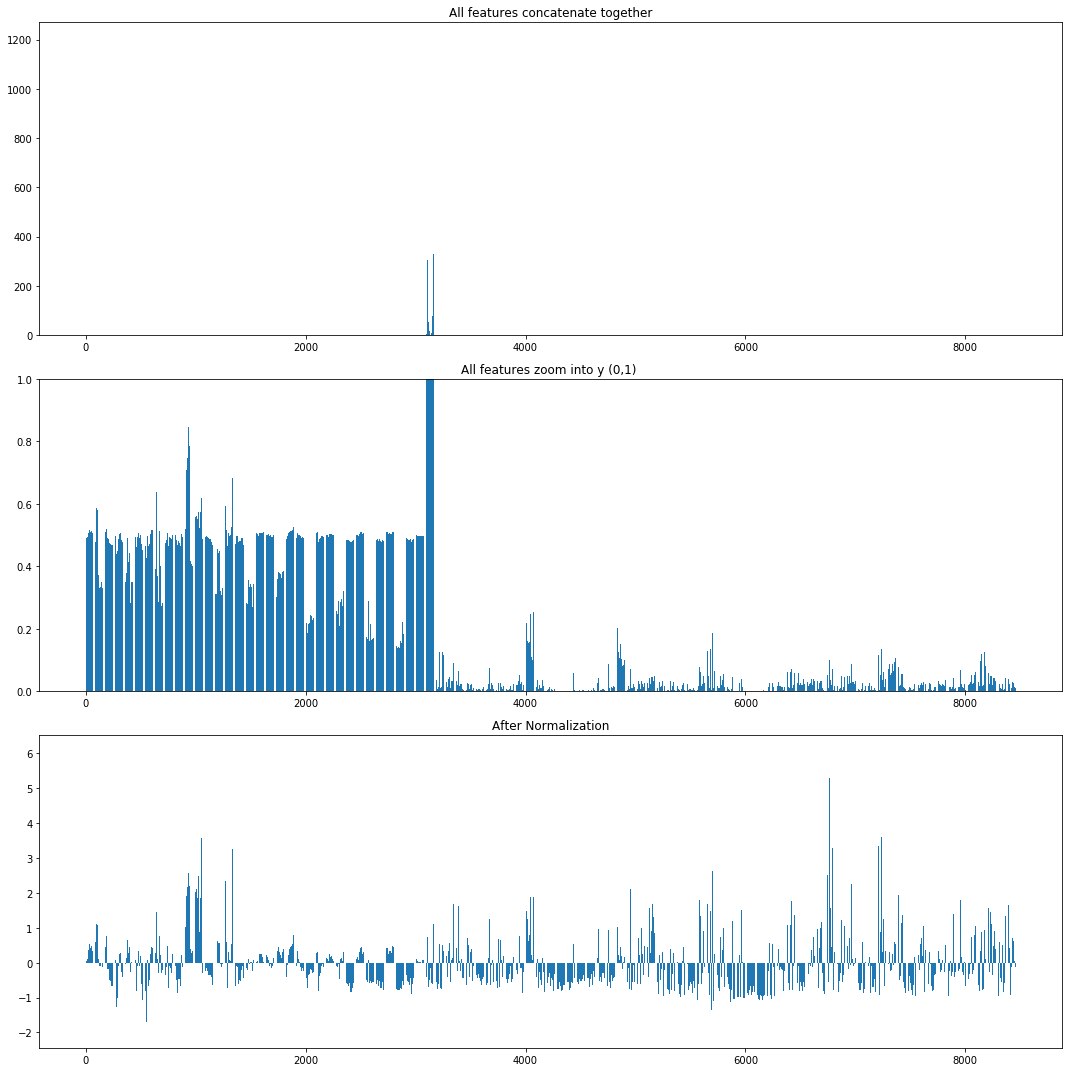

In [9]:
fig = plt.figure(figsize=(15,15))
plt.subplot(311)
feature_len =len(car_features[0])
plt.bar(range(feature_len), car_features[0])
plt.title('All features concatenate together')
plt.subplot(312)
plt.bar(range(feature_len), car_features[0])
plt.ylim(0, 1)
plt.title('All features zoom into y (0,1) ')
plt.subplot(313)
plt.bar(range(feature_len), scaled_X[0])
#plt.xlim(0, 256)
plt.title('After Normalization')
fig.tight_layout()

## save normalized features and labels

In [9]:
# # save feature and labels for later use
# with open('scaled_features.pickle', 'wb') as f:
#      pickle.dump([scaled_X,y,X_scaler], f)

## Load normalized features and labels

In [4]:
# # load feature, labels, and scaler for normalization
# with open('scaled_features.pickle', 'rb') as f:
#      scaled_X,y,X_scaler = pickle.load(f)

# Train classifier
SVM is a very time consuming method, the complexity is O(n_feature * n_obervations^2). So when I use grid search on 8k features with 16k images. It's takes me more then 24 hours on my laptop without finishing. So I opened an AWS 16GB CPU instance to run this task. However with the fear of AWS running forever, I removed 3k features on color space. 

A few notes I found about SVM kernels:
- RBF kernels are general purpose usually the first thing to try if you are not processing text
- Linear kernels are good for text and they are needed for performance if you have a lot of data.

In [10]:
# Split up data into randomized training and test sets

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

# print('Using:',orient,'orientations',pix_per_cell,
#     'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a SVC with grid search
param_grid = [
  {'C': [1,10], 'kernel': ['linear']} #'linear', 'gamma': np.logspace(-2, 1, 5 )
 ]
# Check the training time for the SVC
t=time.time()
svr = SVC()
svc = grid_search.GridSearchCV(svr, param_grid)
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print("The best parameters are %s with a score of %0.4f"
      % (svc.best_params_, svc.best_score_))

Feature vector length: 8460
519.45 Seconds to train SVC...
The best parameters are {'kernel': 'linear', 'C': 1} with a score of 0.9911


In [19]:
svc.get_params()

{'cv': None,
 'error_score': 'raise',
 'estimator': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'estimator__C': 1.0,
 'estimator__cache_size': 200,
 'estimator__class_weight': None,
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': None,
 'estimator__degree': 3,
 'estimator__gamma': 'auto',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': -1,
 'estimator__probability': False,
 'estimator__random_state': None,
 'estimator__shrinking': True,
 'estimator__tol': 0.001,
 'estimator__verbose': False,
 'fit_params': {},
 'iid': True,
 'n_jobs': 1,
 'param_grid': [{'C': [1],
   'gamma': array([  1.,  10.]),
   'kernel': ['linear']}],
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'scoring': None,
 'verbose': 0}

In [30]:
# with open('svm_gridCV_model.pickle', 'wb') as f:
#      pickle.dump(svc, f)

In [6]:
# with open('svm_model.pickle', 'rb') as f:
#     svc = pickle.load(f)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LinearSVC from version 0.18.1 when using version 0.18. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


# Car Detection

Here is my approach to exclude false positives:

Threshold prediction probability: In order to make our classifier more reliable I put a threshold on the confidence score. Only vehicles that got detected with more than 99% probability are taken into consideration.

Heatmap technique for several consecutive frames: I take advantage of the fact that wa are working with an image stream. Instead of drawing the detection windows frame by frame, I take in intervals of 30 frames. This leads to a better result in the heatmap technique and creates a much smoother annotation.

Use cv2.groupRectangles to group detection windows with similar coordinates. This method proves very powerful to sort out false positives because we can put a threshold on the minimum number of rectangles, that need to be detected to form a group. I set the threshold to 10. This means that we need at least 10 windows with similar coordinates in a certain area to get a valid detection. The relative difference between sides of each rectangles to merge them into a group is called Epsilon and I set it to 0.1. Both epsilon and minimum group threshold were tuned by experiment.

I personally found it useful going through all those steps and apply manual feature extraction.
It made me more aware of what can go wrong in object detection. Yo could argue that NN's would be more effective for this task. But they are also black boxes. Doing things the manual way is a bit cumbersome but it is very good practice.

In [11]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial, hist_bins):
    
    draw_img = np.copy(img)
    # Since we trained on .png with range (0,1), and we load .ipeg from video with range (0,255), so we do '/255'
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space='YCrCb') #RGB2YCrCb
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
#     print(ctrans_tosearch.shape)   
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step 75% overlap (8 * 8 cells, )
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    count = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (spatial,spatial))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.concatenate((spatial_features, hist_features,hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img,bboxes, count

In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def search_box(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial, hist_bins):
    
    draw_img = np.copy(img)
    # Since we trained on .png with range (0,1), and we load .ipeg from video with range (0,255), so we do '/255'
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, color_space='YCrCb') #RGB2YCrCb
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
#     print(ctrans_tosearch.shape)   
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step 75% overlap (8 * 8 cells, )
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
#     # Compute individual channel HOG features for the entire image
#     hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    count = 0
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
#             # Extract HOG for this patch
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

#             # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (spatial,spatial))
          
#             # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial)
#             hist_features = color_hist(subimg, nbins=hist_bins)
#             # Scale features and make a prediction
#             test_features = X_scaler.transform(np.concatenate((spatial_features, hist_features,hog_features)).reshape(1, -1))    
#             #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#             test_prediction = svc.predict(test_features)

#             if test_prediction == 1:
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)                 
            bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

    return draw_img,bboxes, count

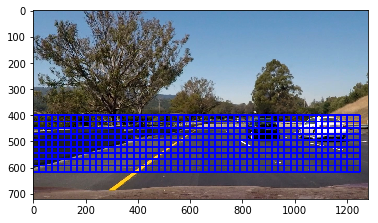

In [23]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb# it can pick up gradient well
orient = 9 #paper says 9 can improve 
pix_per_cell = 8 # 8 is kind of size of features of cars we are looking for 
cell_per_block = 2 # 2 helps the normalization
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 32
ystart = 400
ystop = 656
scale = 1.5
test_imgs = glob.glob('test_images/*.jpg')
img = img = mpimg.imread(test_imgs[2])
# plt.imshow(img)

out_img,box_list, count = search_box(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial, histbin)
plt.imshow(out_img)

## heatmap

In [20]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
#     print(bbox_list)
    for box in bbox_list:
#         print(box)
        
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        
        nonzero = (labels[0] == car_number).nonzero()
#         print(nonzero)
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


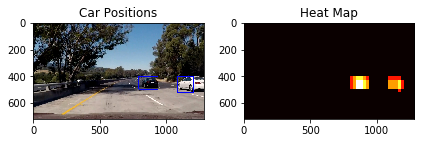

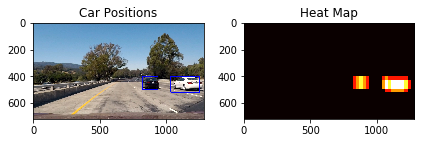

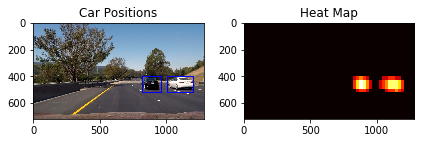

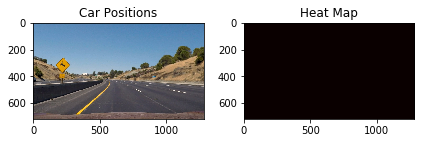

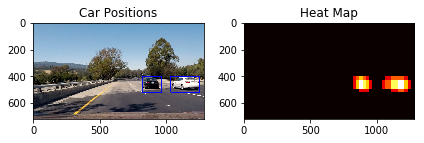

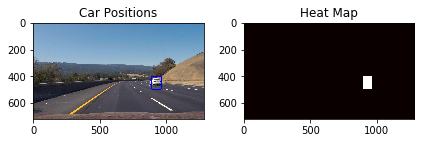

In [21]:
for img in test_imgs:
    
    img = mpimg.imread(img)
    out_img,box_list, count = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial, histbin)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    
# fig.savefig('find_car.png')   # save the figure to file

In [24]:
def process_image(img):
        # can do gridsearch to try all the parameters
    colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb# it can pick up gradient well
    orient = 9 #paper says 9 can improve 
    pix_per_cell = 8 # 8 is kind of size of features of cars we are looking for 
    cell_per_block = 2 # 2 helps the normalization
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial = 32
    histbin = 32
    ystart = 400
    ystop = 656
    scale = 1.5
    
    out_img,box_list, count = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial, histbin)
#     print('No of windows', count)
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img, heat

    

In [29]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
class VehicleTracker:

    def __init__(self, buffer = 5, frame_size = (720,1280)):
        self.buffer_nb = buffer
        self.recent_heat_binary = deque([np.zeros(shape = frame_size).astype(np.float)],maxlen=self.buffer_nb)
        self.current_heat_binary = np.zeros(shape = frame_size).astype(np.float)
#         print(np.shape(self.recent_heat_binary))
        self.current_heatmap = np.zeros(shape = frame_size).astype(np.float)
        self.recent_heatmaps = deque([np.zeros(shape = frame_size).astype(np.float)],maxlen=self.buffer_nb)
#         print(np.shape(self.recent_heatmaps))
    def process_frame(self, frame):
        colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb# it can pick up gradient well
        orient = 9 #paper says 9 can improve 
        pix_per_cell = 8 # 8 is kind of size of features of cars we are looking for 
        cell_per_block = 2 # 2 helps the normalization
        hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
        spatial = 32
        histbin = 32
        ystart = 400
        ystop = 656
        scales = [1, 1.5,2]
        heat = np.zeros_like(frame[:,:,0]).astype(np.float)
        temp = np.zeros(shape = (720,1280))

        for scale in scales:
            _,box_list, _ = find_cars(frame, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial, histbin)
#             box_list.append(box)
#         print(box_list)  
#         heatmaps = deque([],maxlen=self.buffer_nb)    
            heat = add_heat(temp,box_list)
        current_heatmap = apply_threshold(heat,1) # remove False positive
         
        ####
        sum_heatmaps = np.mean(np.array(self.recent_heatmaps), axis=0)
        
        new_frame_factor = 0.7
        add_up = np.multiply(new_frame_factor, current_heatmap) + np.multiply((1-new_frame_factor),sum_heatmaps)
        self.current_heatmap = apply_threshold(add_up,2)
        self.current_heatmap = self.current_heatmap.squeeze()
        
        ## update recent heat maps
        self.recent_heatmaps.appendleft(self.current_heatmap)
              
        
        if np.shape(self.recent_heatmaps)[0] > self.buffer_nb:
            remove_last()
        
#         add_up = np.multiply(new_frame_factor, self.current_heat_binary) + np.multiply((1-new_frame_factor),self.recent_heat_binary)
#         self.current_heatmap = apply_threshold(add_up,0.5)
#         self.current_heatmap = self.current_heatmap.squeeze()
#         self.recent_heatmaps.appendleft(self.current_heatmap)
#         if np.shape(self.recent_heatmaps)[0] > self.buffer_nb:
#             remove_last()
        
#         sum_heatmaps = np.sum(np.array(self.recent_heatmaps), axis=0)
#         self.recent_heat_binary = self.convert_to_ones(sum_heatmaps)
       
        # Visualize the heatmap when displaying    
#         heatmap_thresed = np.clip(heat_thresed, 0, 255)
#         # Find final boxes from heatmap using label function
        
        
        
#         print(np.shape(self.current_heatmap))
        labels = label(self.current_heatmap)
        
        draw_img = draw_labeled_bboxes(np.copy(frame), labels)

#         return draw_img, self.current_heatmap
        return draw_img
    
    def convert_to_ones(self, heat):
        heat = apply_threshold(heat,1) # remove False positive
        return np.clip(heat, 0, 1)
    def remove_last(self):
        self.heatmaps.pop()

In [31]:
vehicleTracker = VehicleTracker(10)
project_video_output = "output.mp4"
clip1 = VideoFileClip("project_video.mp4").subclip(30,31) # select the subclip between t=25s and t=30s
video_clip = clip1.fl_image(vehicleTracker.process_frame)
# video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


 96%|█████████▌| 25/26 [06:03<00:14, 14.53s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 6min 3s, sys: 592 ms, total: 6min 3s
Wall time: 6min 3s


In [32]:
HTML("""
<video width="960" height="540" controls>
   <source src="{0}">
</video> """.format(project_video_output))